# Chapter 5. Predicting Market Movements with Machine Learning
https://learning.oreilly.com/library/view/python-for-algorithmic/9781492053347/ch05.html#idm45785375613352

## Using Logistic Regression to Predict Market Direction

In [12]:
pip install pandas numpy matplotlib scikit-learn

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 9.4 MB/s eta 0:00:0000:01m00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 10.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np

raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
symbol = 'GLD'
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

data.dropna(inplace=True)

hits  1.0    1338
-1.0    1159
 0.0      12
Name: count, dtype: int64
score 0.5338375796178344


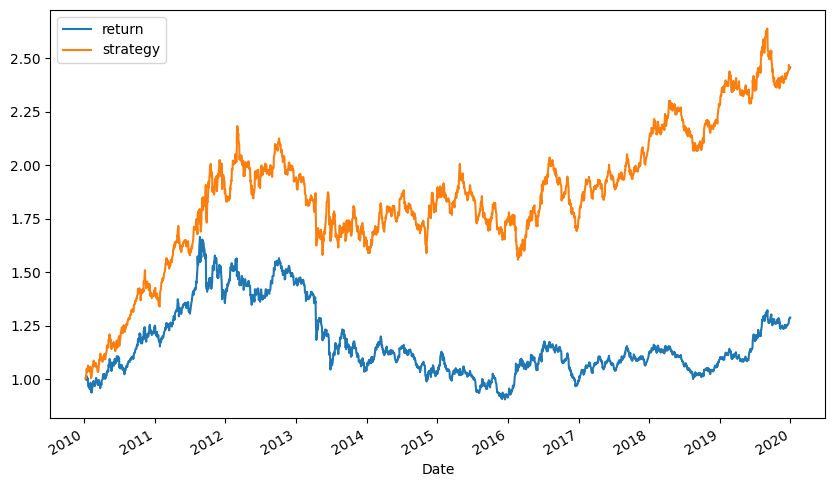

In [14]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                              multi_class='auto',
                                              max_iter=1000)
lm.fit(data[cols], np.sign(data['return']))
# LogisticRegression(C=10000000.0, max_iter=1000)
data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()
hits = np.sign(data['return'].iloc[lags:] *
                         data['prediction'].iloc[lags:]
                        ).value_counts()
print("hits", hits)
score = accuracy_score(data['prediction'],
                         np.sign(data['return']))
print("score", score)
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                                  figsize=(10, 6));

hits  1.0    1331
-1.0    1163
 0.0      12
Name: count, dtype: int64
score 0.5312624452409399


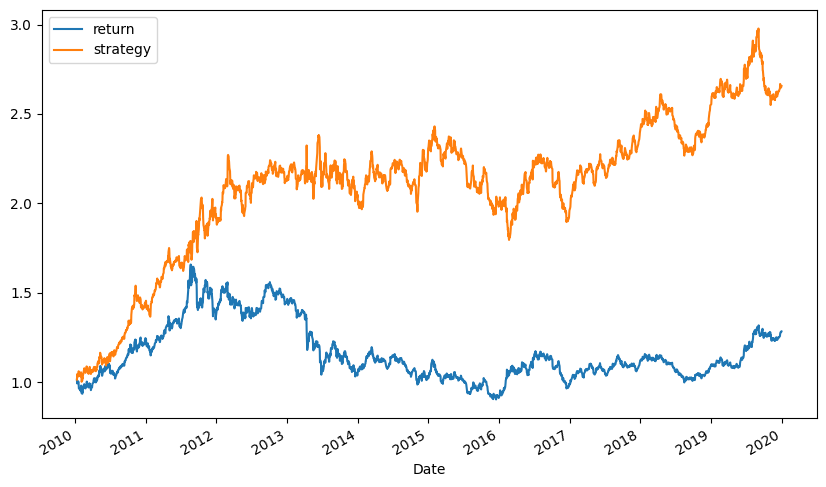

In [3]:
# Increasing the number of lags used from three to five decreases the hit ratio but improves 
# the gross performance of the strategy to some extent (in-sample, before transaction costs). 
# Figure 5-14 shows the resulting performance
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_%d' % lag
    data[col] = data['price'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)
lm.fit(data[cols], np.sign(data['return']))
data['prediction'] = lm.predict(data[cols])
data['prediction'].value_counts()
hits = np.sign(data['return'].iloc[lags:] *
                         data['prediction'].iloc[lags:]
                        ).value_counts()
print("hits", hits)
score = accuracy_score(data['prediction'],
                         np.sign(data['return']))
print("score", score)
data['strategy'] = data['prediction'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)
data[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                                  figsize=(10, 6));

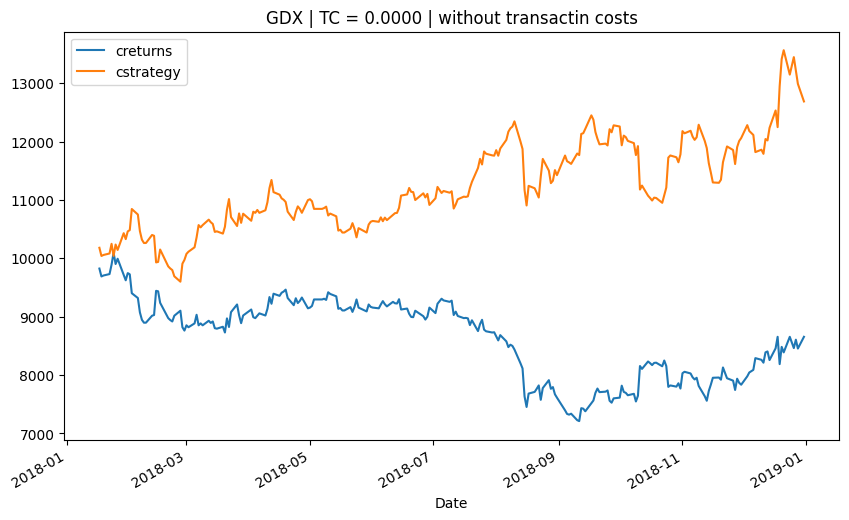

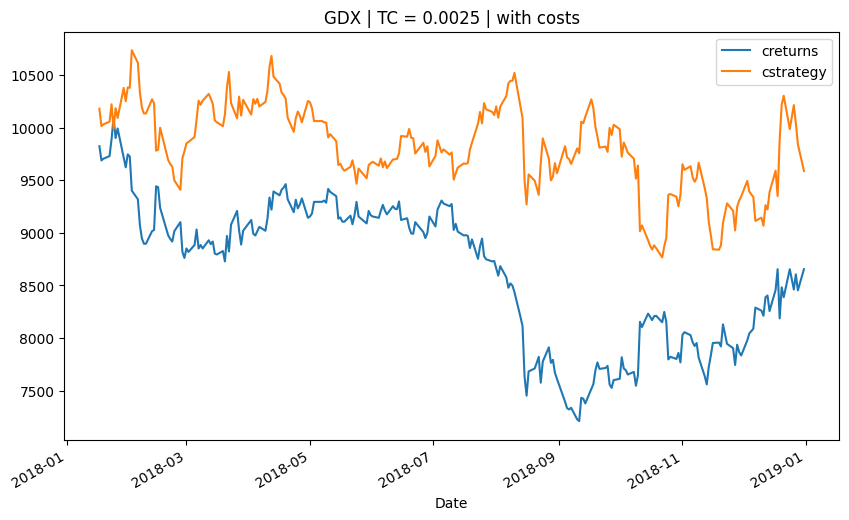

In [6]:
# [128]
# As another example, consider the same strategy applied to the GDX ETF, for which an out-of-sample outperformance 
# (over the year 2018) is shown in Figure 5-16 (before transaction costs):
scibt = ScikitVectorBacktester('GDX',
                               '2010-1-1', '2019-12-31',
                               10000, 0.00, 'logistic')
scibt.run_strategy('2013-1-1', '2017-12-31',
                   '2018-1-1', '2018-12-31', lags=10)
scibt.plot_results("without transactin costs")

# add costs
scibt = ScikitVectorBacktester('GDX',
                                             '2010-1-1', '2019-12-31',
                                             10000, 0.0025, 'logistic')
scibt.run_strategy('2013-1-1', '2017-12-31',
                             '2018-1-1', '2018-12-31', lags=10)
scibt.plot_results("with costs")

### Classification Algorithm Backtesting Class


In [15]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Machine Learning-Based Strategies
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from sklearn import linear_model


class ScikitVectorBacktester(object):
    ''' Class for the vectorized backtesting of
    machine learning-based trading strategies.

    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to work with
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: int, float
        amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade
    model: str
        either 'regression' or 'logistic'

    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    select_data:
        selects a sub-set of the data
    prepare_features:
        prepares the features data for the model fitting
    fit_model:
        implements the fitting step
    run_strategy:
        runs the backtest for the regression-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, symbol, start, end, amount, tc, model):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        if model == 'regression':
            self.model = linear_model.LinearRegression()
        elif model == 'logistic':
            self.model = linear_model.LogisticRegression(C=1e6,
                solver='lbfgs', multi_class='ovr', max_iter=1000)
        else:
            raise ValueError('Model not known or not yet implemented.')
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data.
        '''
        data = self.data[(self.data.index >= start) &
                         (self.data.index <= end)].copy()
        return data

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps.
        '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns],
                       np.sign(self.data_subset['returns']))

    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3):
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        # data = self.select_data(start_out, end_out)
        self.prepare_features(start_out, end_out)
        prediction = self.model.predict(
            self.data_subset[self.feature_columns])
        self.data_subset['prediction'] = prediction
        self.data_subset['strategy'] = (self.data_subset['prediction'] *
                                        self.data_subset['returns'])
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0
        # subtract transaction costs from return when trade takes place
        self.data_subset['strategy'][trades] -= self.tc
        self.data_subset['creturns'] = (self.amount *
                        self.data_subset['returns'].cumsum().apply(np.exp))
        self.data_subset['cstrategy'] = (self.amount *
                        self.data_subset['strategy'].cumsum().apply(np.exp))
        self.results = self.data_subset
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)

    def plot_results(self, title=""):
        ''' Plots the cumulative performance of the trading strategy
        compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | TC = %.4f | %s' % (self.symbol, self.tc, title)
        self.results[['creturns', 'cstrategy']].plot(title=title,
                                                     figsize=(10, 6))


if __name__ == '__main__':
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'regression')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.0, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31'))
    print(scibt.run_strategy('2010-1-1', '2016-12-31',
                             '2017-1-1', '2019-12-31'))
    scibt = ScikitVectorBacktester('.SPX', '2010-1-1', '2019-12-31',
                                   10000, 0.001, 'logistic')
    print(scibt.run_strategy('2010-1-1', '2019-12-31',
                             '2010-1-1', '2019-12-31', lags=15))
    print(scibt.run_strategy('2010-1-1', '2013-12-31',
                             '2014-1-1', '2019-12-31', lags=15))

(11624.45, -16673.78)
(10245.48, -3993.3)
(31490.16, 3191.93)
(13538.46, -700.32)
(32629.37, 3048.08)
(16426.27, -1243.14)


## Using Deep Neural Networks to Predict Market Direction

In [27]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[32],
                               max_iter=1000, random_state=100)
# In [144]
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] /
                                   data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [3]:
# !pip install tensorflow-gpu==2.7.0
# !pip install protobuf==3.19.0

In [2]:
# import os
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
# import tensorflow as tf

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, RMSprop
import random

optimizer = Adam(learning_rate=0.0001)
def set_seeds(seed=100):
              random.seed(seed)
              np.random.seed(seed)
              tf.random.set_seed(100)

set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
                  input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
cutoff = '2017-12-31'


# add features
# In [179]
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['price'] -
                              data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)
cols.extend(['momentum', 'volatility', 'distance'])
print(data.round(4).tail())

# split data
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

# model
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [50]:
%%time
import numpy as np

# Assuming 'cols' is the list of feature column names and 'direction' is the target column
X_train = training_data[cols].values
y_train = training_data['direction'].values

# Fit the model using the NumPy arrays
model.fit(X_train, y_train,
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

# model.fit(training_data[cols],
#                     training_data['direction'],
#                     epochs=50, verbose=False,
#                     validation_split=0.2, shuffle=False)
# res = pd.DataFrame(model.history.history)
# res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

CPU times: user 6.47 s, sys: 606 ms, total: 7.08 s
Wall time: 4.72 s


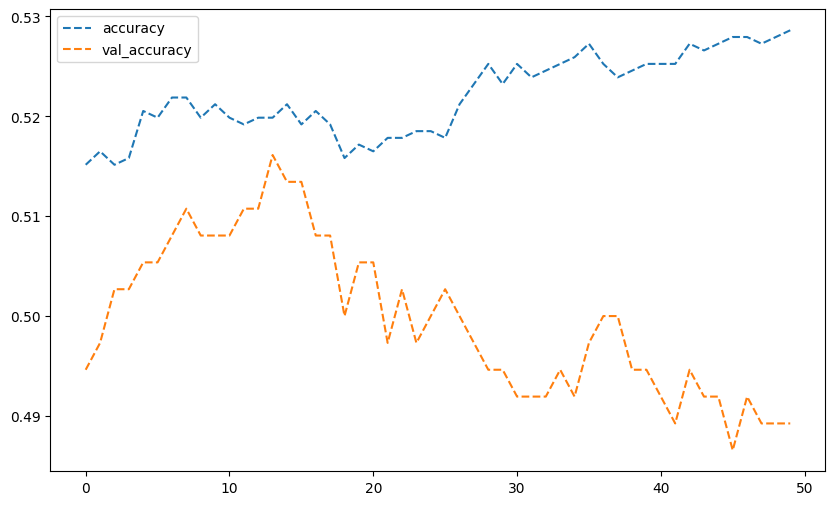

In [51]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

59/59 [==============================] - 0s 819us/step - loss: 0.6926 - accuracy: 0.5191


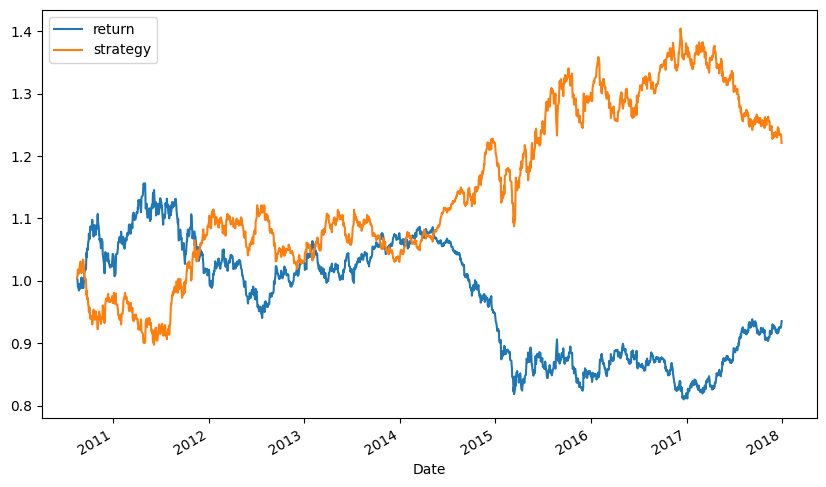

In [52]:
model.evaluate(X_train, y_train)

pred = np.where(model.predict(X_train) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] *
                                       training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)
training_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6));